In [ ]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
# from google.colab import files
from pyDOE import lhs
from scipy.fftpack import diff, fft, ifft
from scipy.integrate import odeint

import time

2025-04-09 20:23:52.915610: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 20:23:52.926264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744239232.935971 1831094 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744239232.938547 1831094 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744239232.945469 1831094 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# Boundaries of the computational domain
xleft, xright = -5000, 5000
t0, tfinal = 0, 1345.7104

# Gravitational constant
g = 9.81

### Subclassing layers

In [ ]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return (inputs-self.xmin)/(self.xmax-self.xmin)

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [ ]:
# Scales of the problem
U = 5.0
H = 20
T = tfinal

# Bottom topography
h0c = 10
a = 3000
B = 5

# Initial conditions
omega = tf.sqrt(2*g*h0c)/a
z0 = lambda x: h0c*(x/a)**2
hh0 = lambda x: h0c - B**2/4/g*(1 + tf.cos(2*omega*t0)) - B*x/2/a*tf.sqrt(8*h0c/g)*tf.cos(omega*t0)
uu0 = lambda x: B*a*omega/tf.sqrt(2*h0c*g)*tf.sin(omega*t0) + 0*x

h0 = lambda x: tf.math.maximum(hh0(x), z0(x)) - z0(x)
u0 = lambda x: uu0(x)

I0000 00:00:1744239235.687499 1831094 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20403 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


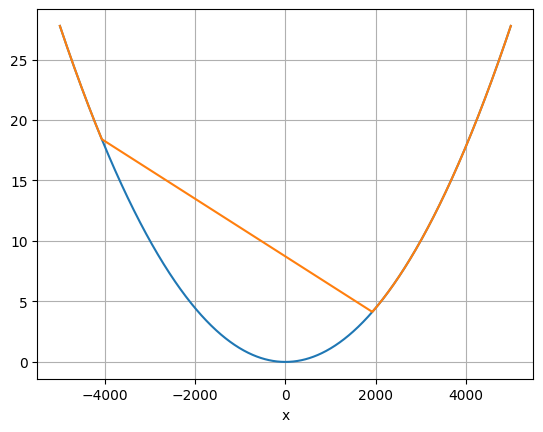

In [ ]:
x = np.linspace(xleft, xright, 1000).astype(np.float32)
plt.plot(x, z0(x))
plt.plot(x, h0(x)+z0(x))
plt.xlabel('x')
plt.grid()

In [ ]:
def build_model(n_units=40, n_layers=4):

  # Define the network
  inp1 = tf.keras.layers.Input(shape=(1,))
  b1 = Normalize(t0, tfinal)(inp1)

  inp2 = tf.keras.layers.Input(shape=(1,))
  b2 = Normalize(xleft, xright)(inp2)
  b = tf.keras.layers.Concatenate()([b1, b2])

  for i in range(n_layers):
    b = tf.keras.layers.Dense(n_units, activation='tanh')(b)
  u = tf.keras.layers.Dense(1, activation='linear')(b)
  h = tf.keras.layers.Dense(1, activation='linear')(b)
  # u = tf.keras.layers.Lambda(lambda x: tf.where(x[0]>=0, x[1], 0.0))([h, u])

  model = tf.keras.models.Model([inp1, inp2], [u, h])

  return model

In [ ]:
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_1         │ (None, 1)         │          0 │ input_layer[0][0] │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_3         │ (None, 1)         │          0 │ input_layer_1[0]… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ normalize_1[0][0… │
│ (Concatenate)       │                   │            │ normalize_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40)        │        120 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40)        │      1,640 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 40)        │      1,640 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 40)        │      1,640 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         41 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         41 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,122 (20.01 KB)

 Trainable params: 5,122 (20.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def defineCollocationPoints(t_bdry, x_bdry, N_pde=10000, N_ic=100):

  # Convert input to numpy array
  t_bdry, x_bdry = np.array(t_bdry), np.array(x_bdry)

  # Uniform random sampling for PDE points
  tx_min = np.array([t_bdry[0], x_bdry[0]])
  tx_max = np.array([t_bdry[1], x_bdry[1]])
  pde_points = tx_min + (tx_max - tx_min)*lhs(2, N_pde)
  t_pde = pde_points[:, 0]
  x_pde = pde_points[:, 1]

  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde]).astype(np.float32)

  # Sample points where to evaluate the initial values
  init_points = tx_min[1:] + (tx_max[1:] - tx_min[1:])*lhs(1, N_ic)
  x_init = init_points
  t_init = t_bdry[0]+ 0.0*x_init
  u_init = u0(x_init)
  h_init = h0(x_init)
  inits = np.column_stack([t_init, x_init, u_init, h_init]).astype(np.float32)

  return pdes, inits

In [ ]:
@tf.function
def trainStep(pdes, ics, model):

  t, x = pdes[:,:1], pdes[:,1:2]
  ti, xi, ui, hi = ics[:,:1], ics[:,1:2], ics[:,2:3], ics[:,3:4]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(t), tape1.watch(x)
      [u, h] = model([t, x])
      z = z0(x)
      hu = h*u
      flux = h*u**2 + 0.5*g*h**2

    # Required derivatives
    ht = tape1.gradient(h, t)
    fluxx = tape1.gradient(flux, x)
    zx = tape1.gradient(z, x)
    [hut, hux] = tape1.gradient(hu, [t, x])

    # Solve the shallow-water equations
    eqn1 = ht + hux
    eqn2 = hut + fluxx + g*h*zx

    # Define the PDE loss
    PDEloss = tf.reduce_mean((T/H*eqn1)**2 + (T/(H*U)*eqn2)**2)

    # Initial value loss
    [ui_pred, hi_pred] = model([ti, xi])
    ICloss = tf.reduce_mean((ui*hi-ui_pred*hi_pred)**2/(H*U)**2 + (hi-hi_pred)**2/H**2)
    # ICloss = tf.reduce_mean((ui-ui_pred)**2/U**2 + (hi-hi_pred)**2/H**2)

    loss = PDEloss + ICloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return loss, grads

In [ ]:
def PINNtrain(pde_points, ic_points, epochs=1000):

  # Optimizer for the problem
  lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-4, decay_steps=epochs,
                                                     end_learning_rate=1e-4)
  opt = tf.keras.optimizers.Adam(lr)

  # Number of collocation points
  nr_pde_points = len(pde_points)
  nr_ic_points = len(ic_points)

  # Batch sizes
  batch_factor = 10
  bs_pde = nr_pde_points//(batch_factor)
  bs_ics = nr_ic_points//(batch_factor)

  # Epoch loss initialization
  epoch_loss = np.zeros(epochs)

  # tf dataset for collocation points
  ds_pde = tf.data.Dataset.from_tensor_slices(pde_points)
  ds_pde = ds_pde.shuffle(nr_pde_points).batch(bs_pde)

  ds_init = tf.data.Dataset.from_tensor_slices(ic_points)
  ds_init = ds_init.cache().shuffle(nr_ic_points).batch(bs_ics)

  # Combine the datasets
  ds = tf.data.Dataset.zip((ds_pde, ds_init))

  # Main training loop
  for i in range(epochs):

    nr_batches = 0

    # Train the model
    for (pdes, ics) in ds:

      # Train the network
      loss, grads = trainStep(pdes, ics, model)

      # Gradient step
      opt.apply_gradients(zip(grads, model.trainable_variables))

      epoch_loss[i] += loss
      nr_batches += 1

    epoch_loss[i] /= nr_batches

    if (np.mod(i, 100)==0):
      print(f"Total loss in {i}th epoch: { epoch_loss[i]: 6.4f}")

  return epoch_loss

In [ ]:
N_pde = 10000
N_ic = 100
pdes, ics = defineCollocationPoints([t0, tfinal], [xleft, xright], N_pde, N_ic)

In [ ]:
epochs = 20000
loss = PINNtrain(pdes, ics, epochs)

Total loss in 0th epoch:  0.0002
Total loss in 100th epoch:  0.0000
Total loss in 200th epoch:  0.0000
Total loss in 300th epoch:  0.0000
Total loss in 400th epoch:  0.0000
Total loss in 500th epoch:  0.0000
Total loss in 600th epoch:  0.0000
Total loss in 700th epoch:  0.0000
Total loss in 800th epoch:  0.0000
Total loss in 900th epoch:  0.0000
Total loss in 1000th epoch:  0.0000
Total loss in 1100th epoch:  0.0000
Total loss in 1200th epoch:  0.0000
Total loss in 1300th epoch:  0.0000
Total loss in 1400th epoch:  0.0000
Total loss in 1500th epoch:  0.0000
Total loss in 1600th epoch:  0.0000
Total loss in 1700th epoch:  0.0000
Total loss in 1800th epoch:  0.0000
Total loss in 1900th epoch:  0.0000
Total loss in 2000th epoch:  0.0000
Total loss in 2100th epoch:  0.0000
Total loss in 2200th epoch:  0.0000
Total loss in 2300th epoch:  0.0000
Total loss in 2400th epoch:  0.0000
Total loss in 2500th epoch:  0.0000
Total loss in 2600th epoch:  0.0000
Total loss in 2700th epoch:  0.0000
Tota

2025-04-10 12:11:40.591274: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total loss in 7800th epoch:  0.0000
Total loss in 7900th epoch:  0.0000
Total loss in 8000th epoch:  0.0000
Total loss in 8100th epoch:  0.0000
Total loss in 8200th epoch:  0.0000
Total loss in 8300th epoch:  0.0000
Total loss in 8400th epoch:  0.0000
Total loss in 8500th epoch:  0.0000
Total loss in 8600th epoch:  0.0000
Total loss in 8700th epoch:  0.0000
Total loss in 8800th epoch:  0.0000
Total loss in 8900th epoch:  0.0000
Total loss in 9000th epoch:  0.0000
Total loss in 9100th epoch:  0.0000
Total loss in 9200th epoch:  0.0000
Total loss in 9300th epoch:  0.0000
Total loss in 9400th epoch:  0.0000
Total loss in 9500th epoch:  0.0000
Total loss in 9600th epoch:  0.0000
Total loss in 9700th epoch:  0.0000
Total loss in 9800th epoch:  0.0000
Total loss in 9900th epoch:  0.0000
Total loss in 10000th epoch:  0.0000
Total loss in 10100th epoch:  0.0000
Total loss in 10200th epoch:  0.0000
Total loss in 10300th epoch:  0.0000
Total loss in 10400th epoch:  0.0000
Total loss in 10500th e

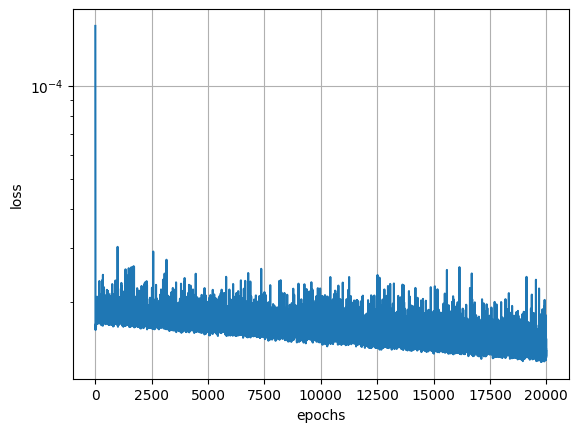

In [ ]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.grid()

In [ ]:
# Grid where to evaluate the model
l, m = int(tfinal)+1, 200
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m, endpoint=False)
TT, XX = np.meshgrid(t, x, indexing='ij')

# Evaluate the model
[u, h] = model([np.expand_dims(TT.flatten(), axis=1),
                np.expand_dims(XX.flatten(), axis=1)])

u = np.reshape(u, (l, m))
h = np.reshape(h, (l, m))
b = np.reshape(z0(XX.flatten()), (l, m))

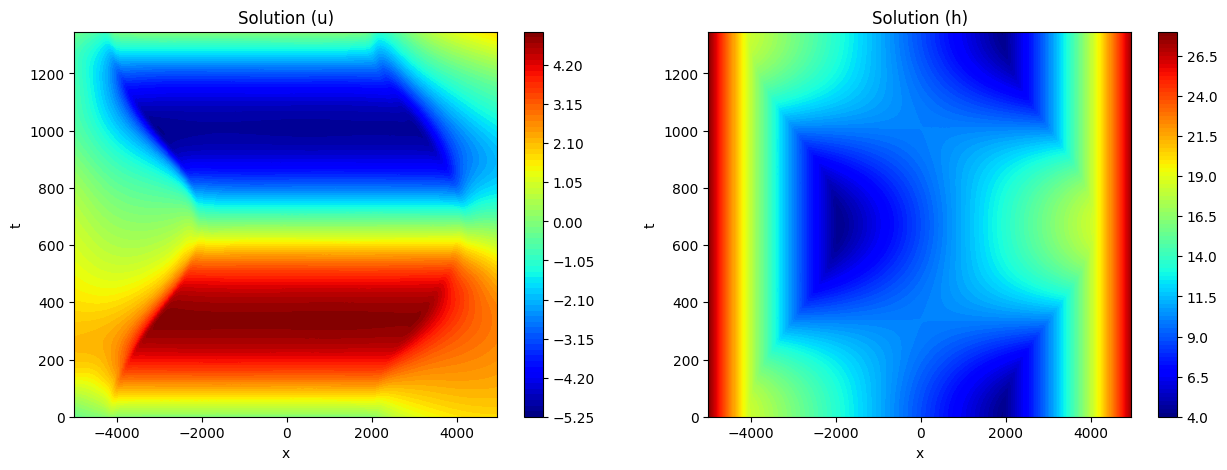

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.contourf(XX, TT, u, 100, cmap=plt.cm.jet)
plt.title('Solution (u)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(122)
plt.contourf(XX, TT, h + b, 100, cmap=plt.cm.jet)
plt.title('Solution (h)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

Text(0, 0.5, 'h+b')

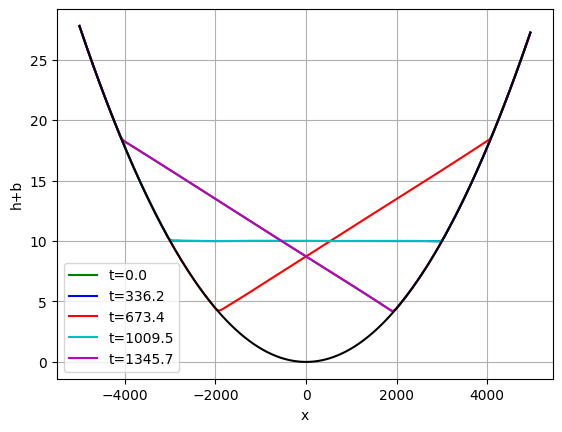

In [ ]:
nr = 5
steps = [i*len(h)//(nr-1) for i in range(nr)]
steps[-1] = -1
colors = ['g','b','r','c','m','y']

for c, p in zip(colors,steps):
  plt.plot(x, h[p,]+b[p,], color=c, label=f't={t[p]:.1f}')
plt.plot(x, b[p,],'k')
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')

In [ ]:
hexact = lambda t, x: h0c - B**2/4/g*(1 + tf.cos(2*omega*t)) - B*x/2/a*tf.sqrt(8*h0c/g)*tf.cos(omega*t)
htrue = lambda t, x: tf.math.maximum(hexact(t,x), z0(x)) - z0(x)

In [ ]:
hreference = htrue(TT, XX)

In [ ]:
np.pi/omega

<tf.Tensor: shape=(), dtype=float32, numpy=672.855224609375>

In [ ]:
print(steps)
print(t[steps])

[0, 336, 673, 1009, -1]
[   0.          336.17746796  673.35546409 1009.53293204 1345.7104    ]


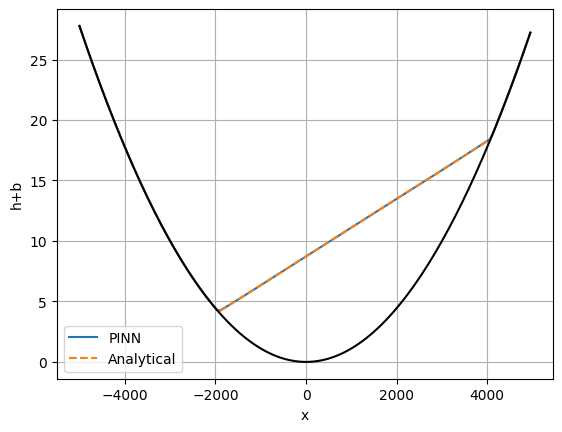

In [ ]:
p = 673
plt.plot(x, h[p,]+b[p,], label='PINN')
plt.plot(x, hreference[p,]+b[p,], '--', label='Analytical')

plt.plot(x, b[p,],'k')
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')
plt.savefig(f'Step{p}Bowl.png', dpi=300, bbox_inches='tight')

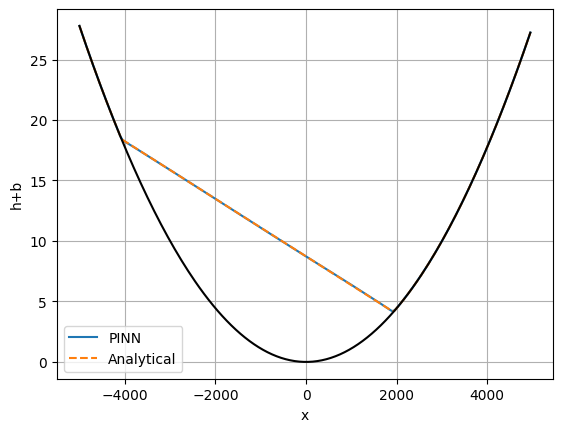

In [ ]:
p = -1
plt.plot(x, h[p,]+b[p,], label='PINN')
plt.plot(x, hreference[p,]+b[p,], '--', label='Analytical')

plt.plot(x, b[p,],'k')
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')
plt.savefig(f'Step{p}Bowl.png', dpi=300, bbox_inches='tight')

In [ ]:
err = np.linalg.norm(h-hreference, ord=2, axis=1)/np.linalg.norm(hreference+b, ord=2, axis=1)

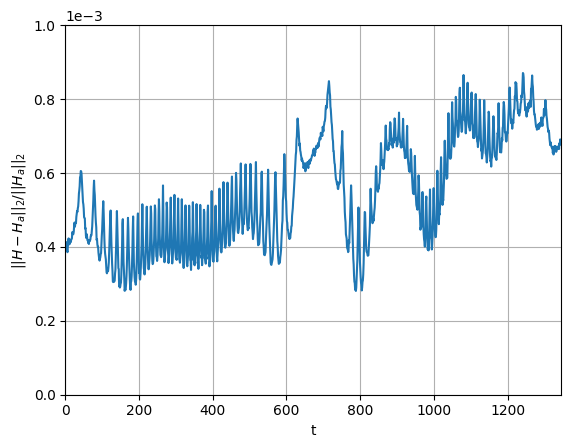

In [ ]:
fig, ax = plt.subplots()

plt.plot(t, err)
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$||H-H_a||_2/||H_a||_2$')
ax.set_xlim(0.0, tfinal)
ax.set_ylim(0.0, 0.0010)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('errorBowlTimeSeries1D.png', dpi=300, bbox_inches='tight')

In [ ]:
mass = np.sum(h, axis=1)

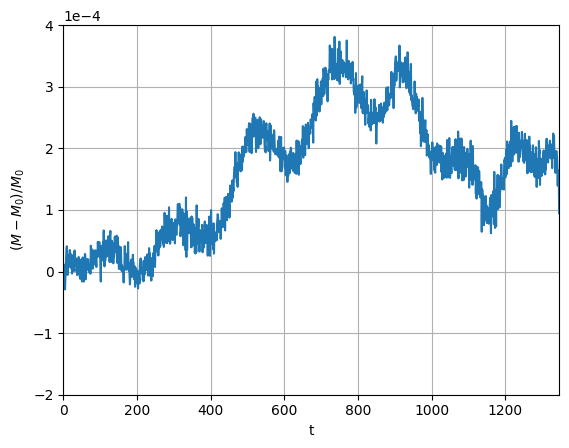

In [ ]:
fig, ax = plt.subplots()

plt.plot(t, (mass-mass[0])/mass[0])
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$(M-M_0)/M_0$')
ax.set_xlim(0.0, tfinal)
ax.set_ylim(-0.0002, 0.0004)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('massTimeSeriesBowl1D.png', dpi=300, bbox_inches='tight')

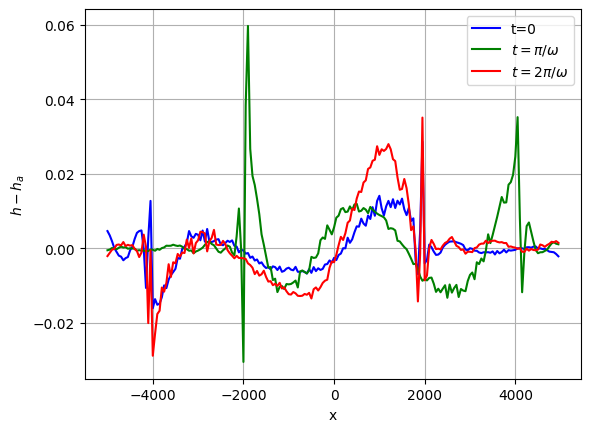

In [ ]:
nr = 3
steps = [i*len(h)//(nr-1) for i in range(nr)]
steps[-1] = -1
colors = ['b','g','r','c','m','y']
legends = ['t=0', r'$t=\pi/\omega$', r'$t=2\pi/\omega$']

for c, p, l in zip(colors,steps,legends):
  plt.plot(x, (h[p,]-hreference[p,]), color=c, label=l)
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$h-h_a$')
plt.savefig('errorBowl.png', dpi=300, bbox_inches='tight')